In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Pg 145
# J&J Quarterly EPS since January 1960 to  december 1980
df = pd.read_csv('../data/jj.csv')
df.tail() # shape (84, 2)

,date,data
79,1979-10-01,9.99
80,1980-01-01,16.20
81,1980-04-01,14.67
82,1980-07-02,16.02
83,1980-10-01,11.61


In [3]:
train = df.iloc[:-4]
test= df.iloc[-4:]

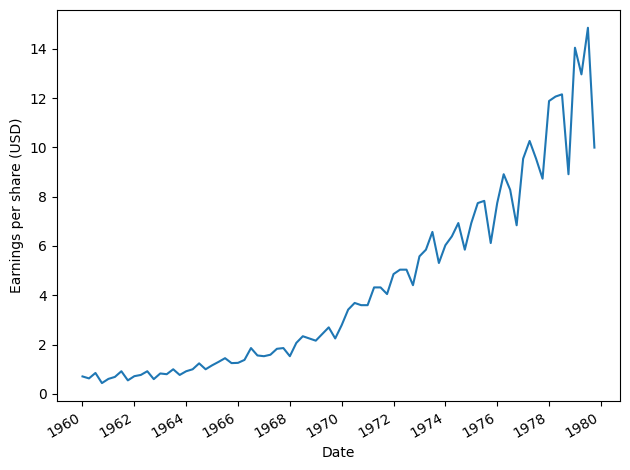

In [4]:
# Figure 7.5 in pg 147

fig, ax = plt.subplots()

ax.plot(train.date, train['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()


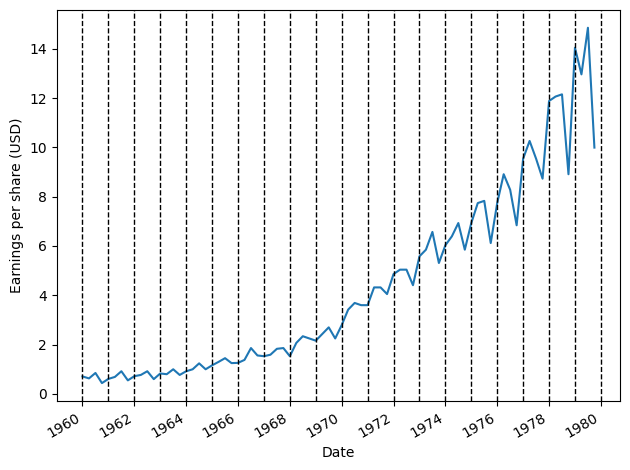

In [5]:
fig, ax = plt.subplots()

ax.plot(train.date, train['data'])
for i in np.arange(0, 84, 4):
    ax.axvline(x=i, linestyle='--', color='black', linewidth=1)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 84, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

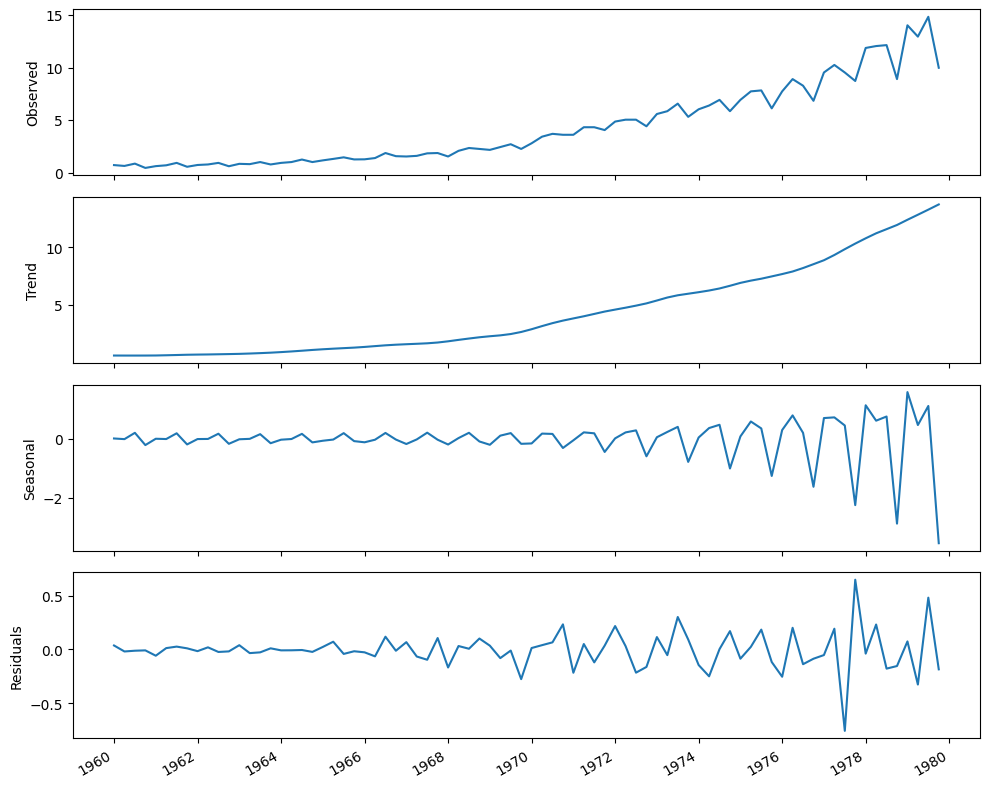

In [6]:
decomposition = STL(train['data'], period=4).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0, 84, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

In [7]:
ad_fuller_result = adfuller(train['data'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 4.990525443391484
p-value: 1.0


In [8]:
df_diff = np.diff(train['data'], n=1)

ad_fuller_result = adfuller(df_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')
df_diff.std()

ADF Statistic: 1.0549818780548506
p-value: 0.9948134914948294


np.float64(1.150594241574943)

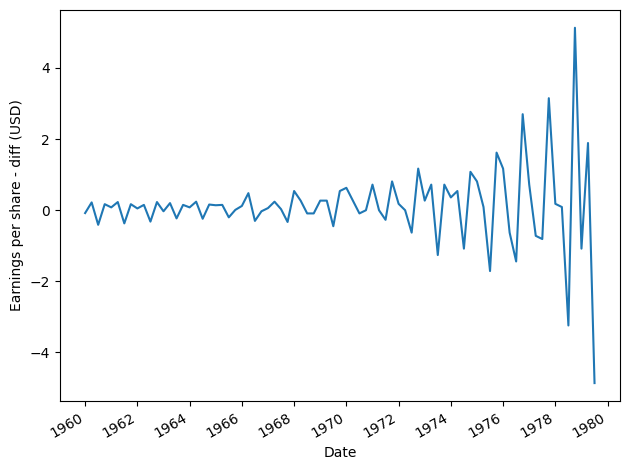

In [9]:
fig, ax = plt.subplots()

ax.plot(train['date'][1:], df_diff)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share - diff (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

In [10]:
#df_diff_seasonal_diff = np.diff(df_diff, n=4)       # n=4 differences lag 1 4 consecutive times, instead do:
df_diff_seasonal_diff = df_diff[4:] - df_diff[:-4]  # type:numpy.ndarray # this differences once lag 4, which is what we want

ad_fuller_result = adfuller(df_diff_seasonal_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')
df_diff_seasonal_diff.std()

ADF Statistic: -6.386493872385145
p-value: 2.157791414009534e-08


np.float64(0.5954743261935049)

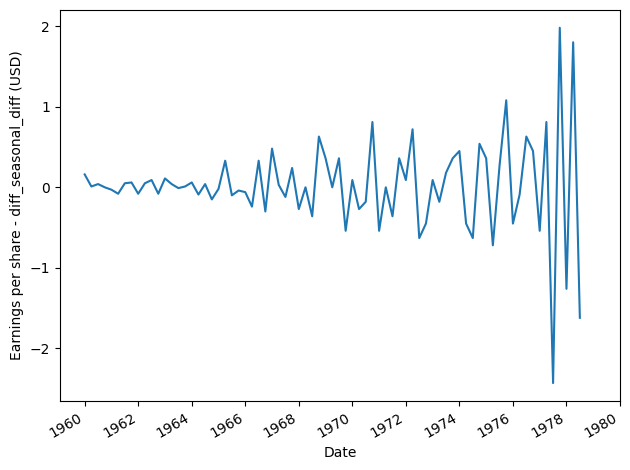

In [11]:
fig, ax = plt.subplots()

ax.plot(train['date'][5:], df_diff_seasonal_diff)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share - diff_seasonal_diff (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

## d=1, D=1

In [12]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
ps = range(0, 5, 1)
qs = range(0, 5, 1)
Ps = range(0, 5, 1)
Qs = range(0, 5, 1)

d = 1
D = 1
s = 4

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

SARIMA_result_df = optimize_SARIMA(train['data'], SARIMA_order_list, d, D, s)
SARIMA_result_df

In [ ]:
SARIMA_result_df[:20]

	(p,q,P,Q)	AIC   
0	(1, 4, 1, 0)	88.179833  
1	(3, 0, 2, 1)	88.835578  
2	(4, 2, 0, 3)	89.294286  
3	(1, 2, 0, 0)	89.609996  
4	(3, 1, 0, 0)	89.677549  
5	(1, 3, 0, 0)	89.734025  
6	(2, 4, 1, 0)	89.828180  
7	(1, 4, 2, 0)	90.009389  
8	(2, 2, 0, 0)	90.178107  
9	(1, 4, 3, 0)	90.192600  
10	(3, 0, 0, 1)	90.208482  
11	(3, 0, 1, 0)	90.260749  
12	(3, 3, 1, 3)	90.459934  
13	(1, 2, 0, 4)	90.625285  
14	(3, 0, 0, 0)	90.769204  
15	(3, 3, 1, 2)	90.805163  
16	(1, 3, 0, 4)	90.808605  
17	(4, 3, 0, 3)	90.872525  
18	(2, 2, 0, 4)	91.104762  
19	(3, 4, 0, 0)	91.189153  

***************************************************************************
Pick a Model and analyze residuals

We pick SARIMA(1,1,4)(1,1,0)_4, which has the lowest AIC

In [13]:
SARIMA_model = SARIMAX(train['data'], order=(1,1,4), seasonal_order=(1,1,0,4), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False, method='powell')#, method='nm') # method='powell'

print(SARIMA_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               data   No. Observations:                   80
Model:             SARIMAX(1, 1, 4)x(1, 1, [], 4)   Log Likelihood                 -37.125
Date:                            Tue, 10 Feb 2026   AIC                             88.250
Time:                                    20:16:15   BIC                            104.472
Sample:                                         0   HQIC                            94.727
                                             - 80                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7805      0.106     -7.338      0.000      -0.989      -0.572
ma.L1          0.0655      0.125   

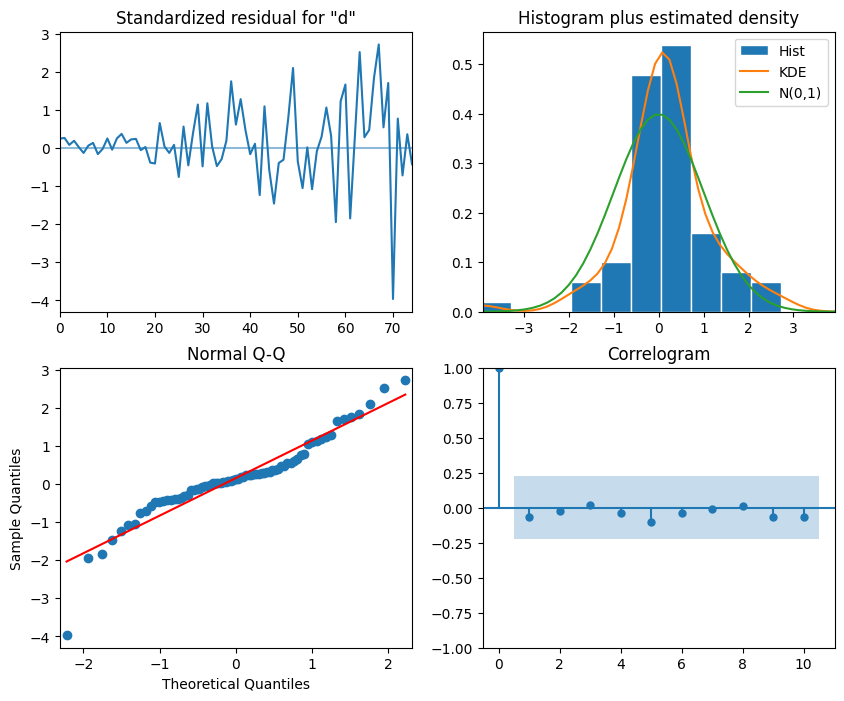

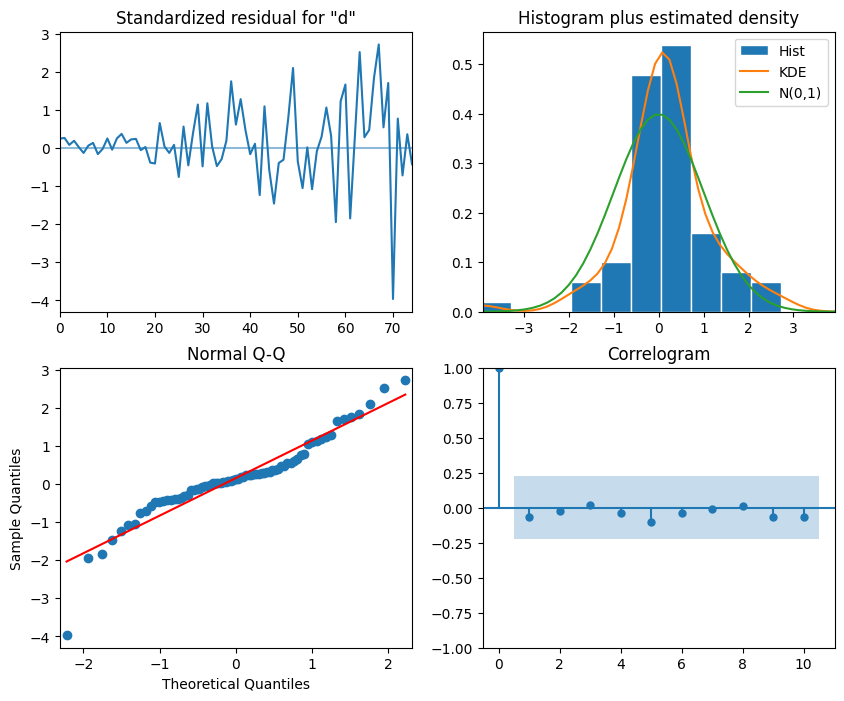

In [14]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [15]:
residuals = SARIMA_model_fit.resid

lb_dataframe = acorr_ljungbox(residuals, np.arange(1, 11, 1))

lb_dataframe

,lb_stat,lb_pvalue
1,0.407244,0.523371
2,0.434361,0.804785
3,0.439150,0.932041
4,0.678308,0.953977
5,1.389928,0.925412
6,1.452121,0.962611
7,1.457477,0.983745
8,1.468880,0.993213
9,1.786691,0.994409
10,2.107880,0.995444


Residuals are non correlated

*******************************************************************************************
Forecast with model

In [16]:
SARIMA_model = SARIMAX(train['data'], order=(1,1,4), seasonal_order=(1,1,0,4), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False, method='powell')#, method='nm') # method='powell'

#print(SARIMA_model_fit.summary())

In [17]:
test['naive_seasonal'] = df['data'].iloc[76:80].values
test

,date,data,naive_seasonal
80,1980-01-01,16.20,14.04
81,1980-04-01,14.67,12.96
82,1980-07-02,16.02,14.85
83,1980-10-01,11.61,9.99


In [18]:
SARIMA_pred = SARIMA_model_fit.get_prediction(80, 83).predicted_mean

test['SARIMA_pred'] = SARIMA_pred
test

,date,data,naive_seasonal,SARIMA_pred
80,1980-01-01,16.20,14.04,16.579999
81,1980-04-01,14.67,12.96,14.032254
82,1980-07-02,16.02,14.85,16.785942
83,1980-10-01,11.61,9.99,11.259449


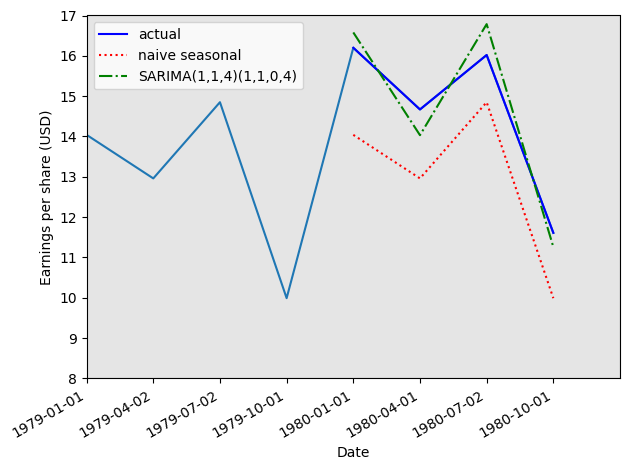

In [19]:
fig, ax = plt.subplots()

ax.plot(df['date'], df['data'])
ax.plot(test['data'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
#ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(11,2,3)')
ax.plot(test['SARIMA_pred'], 'g-.', label='SARIMA(1,1,4)(1,1,0,4)')

ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(75, 84, color='#808080', alpha=0.2)

ax.legend(loc=2)

ax.set_xlim(76, 84)
ax.set_ylim(8, 17)

fig.autofmt_xdate()
plt.tight_layout()


In [20]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [21]:
mape_naive_seasonal = mape(test['data'], test['naive_seasonal'])
mape_SARIMA = mape(test['data'], test['SARIMA_pred'])

print(mape_naive_seasonal, mape_SARIMA)

11.561658552433654 3.6233749020123414


CH07, ARIMA(3,2,3): 1.73% off

CH08_exercise_8.5.1_d=1_D=1, SARIMA(1,1,4)(1,1,0,4)_4, method='nm': 3.49% off  
CH08_exercise_8.5.1_d=1_D=1, SARIMA(1,1,4)(1,1,0,4)_4,method='powell': 3.62% off

CH08_exercise_8.5.1_d=0_D=1: 11.48% off

